In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Flatten,Dense,Dropout,MaxPooling2D,BatchNormalization,AveragePooling2D,GlobalAveragePooling2D,SeparableConv2D,Activation,Add,Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import glob as glb
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import cv2 
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
import os
import shutil
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers 
import pandas as pd
import seaborn as sea

In [2]:
# Text mmodel

In [3]:
train_emo = pd.read_csv("C:/Users/levent/Downloads/Text_dataset/train_sent_emo.csv")
test_emo = pd.read_csv("C:/Users/levent/Downloads/Text_dataset/test_sent_emo.csv")
dev_emo = pd.read_csv("C:/Users/levent/Downloads/Text_dataset/dev_sent_emo.csv")

test_csv = pd.read_csv("C:/Users/levent/Downloads/Text_dataset/Emotion_dataset_test.csv")
train_csv = pd.read_csv("C:/Users/levent/Downloads/Text_dataset/Emotion_dataset_train.csv")

In [4]:
only_neutral_data=pd.read_csv("C:/Users/levent/tr_only_csv")

In [5]:
only_neutral_data

,batch,labels
0,Ayrıca şirketimin KL-5'ten GR-6 sistemine geçi...,neutral
1,Eliniz çok dolu olmalı.,neutral
2,Bunu yaptım. Bunu yaptım.,neutral
3,Peki biraz da görevlerinizden bahsedelim.,neutral
4,"Şimdi bir bölümün başında olacaksın, dolayısıy...",neutral
...,...,...
4705,"Tut, tut.",neutral
4706,Bu konuda Chandler'ın tarafını tutuyorum.,neutral
4707,Sen mi ben mi?,neutral
4708,"Anladım. Joey, kadınların Adem elması yoktur.",neutral


In [6]:
only_neutral_halfdata = only_neutral_data.iloc[:len(only_neutral_data)//5] 

In [7]:
tr_train_data=pd.DataFrame()
tr_train_data['batch']=train_csv['Sentence']
tr_train_data['labels']=train_csv['Label']

In [8]:
tr_test_data=pd.DataFrame()
tr_test_data['batch']=test_csv['Sentence']
tr_test_data['labels']=test_csv['label']

<Axes: xlabel='count', ylabel='labels'>

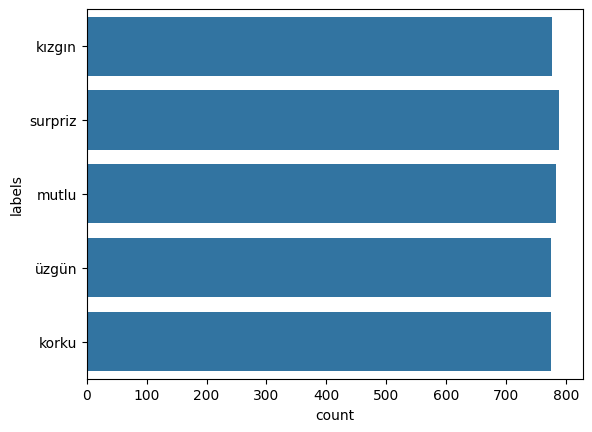

In [9]:
sea.countplot(tr_train_data['labels'])

In [10]:
tr_train_data

,batch,labels
0,Allah aşkına bi fırça neden 250 tl neden yani ...,kızgın
1,Muavin bir şey içip içmediğimi sormak için ben...,surpriz
2,Herkese güzel günler öpüyorum sizler tivitır a...,mutlu
3,Ya şu sevgililerin birbirine şifre verme olayı...,kızgın
4,Almanya'da 'yok artık' dedirten olay! Nereye p...,surpriz
...,...,...
3895,Onu görünce ben de ürktüm bir başta sonra yeni...,korku
3896,Gece sabaha kadar 50 tane kabus gördüm nasıl b...,korku
3897,"Sustum senden sonra, sessize aldım dilimi. Ne ...",korku
3898,mutsuzum çünkü ders çalışamıyorum odaklanamıyo...,üzgün


In [11]:
All_data = pd.concat([tr_train_data,tr_test_data, only_neutral_halfdata], ignore_index=True)

<Axes: xlabel='count', ylabel='labels'>

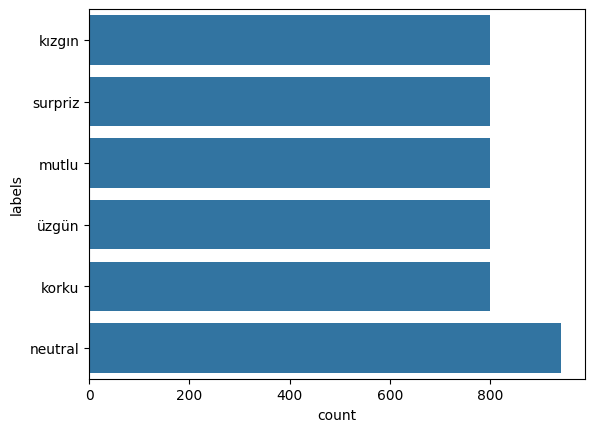

In [12]:
sea.countplot(All_data['labels'])

In [13]:
Filtered_data = All_data[~All_data['labels'].isin(['korku'])]

In [14]:
labels_list = {
    'kızgın': 'angry',
    'mutlu': 'happy',
    'neutral': 'neutral',
    'üzgün': 'sad',
    'surpriz': 'surprised'
}

In [15]:
def list_text_features(label,list):
    if label in list: 
        emotion = list.get(label)
    return emotion

In [16]:
remastered_labels = [list_text_features(path,labels_list) for path in Filtered_data['labels']]

In [17]:
Filtered_data['batch']

0       Allah aşkına bi fırça neden 250 tl neden yani ...
1       Muavin bir şey içip içmediğimi sormak için ben...
2       Herkese güzel günler öpüyorum sizler tivitır a...
3       Ya şu sevgililerin birbirine şifre verme olayı...
4       Almanya'da 'yok artık' dedirten olay! Nereye p...
                              ...                        
4937                           Ben de merak ediyordum....
4938                                      Yani şef misin?
4939    Monica, menümün arkasında seninle konuşabilir ...
4940                             Ben de sohbet ediyordum.
4941                      Harika olurdu. Teşekkür ederim.
Name: batch, Length: 4142, dtype: object

In [18]:
Filtered_data

,batch,labels
0,Allah aşkına bi fırça neden 250 tl neden yani ...,kızgın
1,Muavin bir şey içip içmediğimi sormak için ben...,surpriz
2,Herkese güzel günler öpüyorum sizler tivitır a...,mutlu
3,Ya şu sevgililerin birbirine şifre verme olayı...,kızgın
4,Almanya'da 'yok artık' dedirten olay! Nereye p...,surpriz
...,...,...
4937,Ben de merak ediyordum....,neutral
4938,Yani şef misin?,neutral
4939,"Monica, menümün arkasında seninle konuşabilir ...",neutral
4940,Ben de sohbet ediyordum.,neutral


In [19]:
Last_data=pd.DataFrame()
Last_data['batch']=Filtered_data['batch']
Last_data['labels']=remastered_labels

In [20]:
Last_data['batch']=Last_data['batch'].str.lower()

In [21]:
#gereksiz boşluklar kaldırıldı

def delete_space(text):
    text = str(text)
    return ' '.join(text.split())

Last_data['batch'] = Last_data['batch'].apply(delete_space)

In [22]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
enc = LabelEncoder()
one_hot_labels = enc.fit_transform(Last_data[['labels']])

C:\Users\levent\anaconda3\envs\Gpuenv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('turkish'))

In [24]:
stop_words

{'acaba',
 'ama',
 'aslında',
 'az',
 'bazı',
 'belki',
 'biri',
 'birkaç',
 'birşey',
 'biz',
 'bu',
 'da',
 'daha',
 'de',
 'defa',
 'diye',
 'en',
 'eğer',
 'gibi',
 'hem',
 'hep',
 'hepsi',
 'her',
 'hiç',
 'ile',
 'ise',
 'için',
 'kez',
 'ki',
 'kim',
 'mu',
 'mü',
 'mı',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niye',
 'niçin',
 'o',
 'sanki',
 'siz',
 'tüm',
 've',
 'veya',
 'ya',
 'yani',
 'çok',
 'çünkü',
 'şey',
 'şu'}

In [26]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\levent\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\levent\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [27]:
from nltk.tokenize import word_tokenize
def remove_stopwords(text):
    words = word_tokenize(text.lower())
    filtered_words = [word for word in words if word not in stop_words]
    
    return ' '.join(filtered_words)

In [28]:
r_stopwords = Last_data['batch'].apply(remove_stopwords)

In [29]:
r_stopwords

0       allah aşkına bi fırça 250 tl işin sinir bozucu...
1       muavin bir içip içmediğimi sormak beni uykumda...
2       herkese güzel günler öpüyorum sizler tivitır a...
3       sevgililerin birbirine şifre verme olayına sin...
4       almanya'da 'yok artık ' dedirten olay ! park e...
                              ...                        
4937                             ben merak ediyordum ....
4938                                          şef misin ?
4939    monica , menümün arkasında seninle konuşabilir...
4940                               ben sohbet ediyordum .
4941                    harika olurdu . teşekkür ederim .
Name: batch, Length: 4142, dtype: object

In [30]:
from zemberek.morphology import TurkishMorphology

In [31]:
morphology = TurkishMorphology.create_with_defaults()

2025-01-12 22:24:41,947 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 6.808405637741089



In [32]:
#kelimeler token'lerine ayrıldı

def tokanize(text):
    words = text.split()
    stems = []
    for word in words:
        analysis_results = morphology.analyze(word)
        if analysis_results:
            for analysis in analysis_results:
                if hasattr(analysis, "get_stem"):
                    stems.append(analysis.get_stem())
                    break  
    return stems
word_origins=r_stopwords.apply(tokanize)

In [33]:
word_origins

0       [allah, aşk, fırça, 250, tl, iş, sinir, boz, y...
1       [muavin, bir, iç, iç, sor, ben, uyku, uyan, ha...
2                   [herkes, güzel, günle, öp, siz, alem]
3       [sevgili, birbiri, şifre, ver, olay, sinir, ol...
4       [almanya, artık, dedir, olay, !, park, et, unu...
                              ...                        
4937                                     [ben, merak, ed]
4938                                         [şef, mi, ?]
4939    [monica, ,, menü, arka, sen, konuş, mi, lütfen...
4940                                 [ben, sohbet, ed, .]
4941                     [harika, ol, ., teşekkür, ed, .]
Name: batch, Length: 4142, dtype: object

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

processed_texts = [' '.join(tokens) for tokens in word_origins]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_texts)
sequences = tokenizer.texts_to_sequences(processed_texts)

In [35]:
max_sequence_length = 64
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

In [36]:
from sklearn.model_selection import train_test_split
x_text_train, x_text_temp, y_text_train, y_text_temp = train_test_split(padded_sequences, one_hot_labels, test_size=0.3, random_state=42 )

In [37]:
x_text_test, x_text_val, y_text_test, y_text_val = train_test_split(x_text_temp, y_text_temp, test_size=0.5, random_state=42 )

In [38]:
vocab_size = len(tokenizer.word_index) + 1 # benzersiz kelime sayısı

In [39]:
vocab_size

3927

In [40]:
# image Model

In [41]:
image_path="C:/Users/levent/Downloads/Facial_Emotion_five2/train" 

In [42]:
def create_pd_series(path):
    filepaths = []
    labels = []

    folds = os.listdir(path)
    for fold in folds:
        foldpath = os.path.join(path, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            files=os.path.join(foldpath,file)
             
            filepaths.append(files)
            labels.append(fold)

    Fseries=pd.Series(filepaths,name='filepaths')
    Lseries=pd.Series(labels,name='labels')
    df=pd.concat([Fseries,Lseries],axis=1)
        
    return df

In [43]:
train_df = create_pd_series(image_path)

In [44]:
train_df

,filepaths,labels
0,C:/Users/levent/Downloads/Facial_Emotion_five2...,angry
1,C:/Users/levent/Downloads/Facial_Emotion_five2...,angry
2,C:/Users/levent/Downloads/Facial_Emotion_five2...,angry
3,C:/Users/levent/Downloads/Facial_Emotion_five2...,angry
4,C:/Users/levent/Downloads/Facial_Emotion_five2...,angry
...,...,...
31120,C:/Users/levent/Downloads/Facial_Emotion_five2...,surprise
31121,C:/Users/levent/Downloads/Facial_Emotion_five2...,surprise
31122,C:/Users/levent/Downloads/Facial_Emotion_five2...,surprise
31123,C:/Users/levent/Downloads/Facial_Emotion_five2...,surprise


<Axes: xlabel='count', ylabel='labels'>

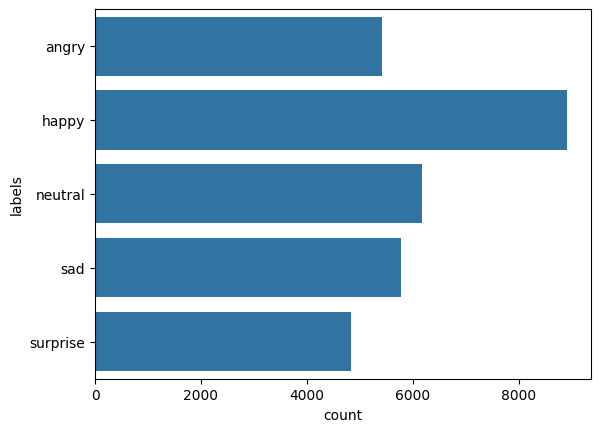

In [45]:
sea.countplot(train_df['labels'])

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
train_df_new, temp_df_new = train_test_split(
    train_df,
    train_size=0.9,  
    shuffle=True,
    random_state=42,
    stratify=train_df['labels']  )

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,  
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['labels'] )

In [48]:
batch_size = 64
img_size = (48, 48)
channels = 1
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rotation_range = 10,
                            zoom_range = 0.2,
                            shear_range = 0.2,
                            fill_mode ='nearest',
                            horizontal_flip = True                           
                           )
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df_new, 
                                       x_col = 'filepaths', 
                                       y_col = 'labels', 
                                       target_size = img_size, 
                                       class_mode = 'sparse',
                                      color_mode = 'grayscale',
                                       shuffle = True, 
                                       batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df_new, 
                                      x_col = 'filepaths',
                                      y_col = 'labels',
                                      target_size = img_size,
                                      class_mode = 'sparse',
                                     color_mode = 'grayscale',
                                      shuffle = False,
                                      batch_size = batch_size)
val_gen = ts_gen.flow_from_dataframe(valid_df_new,
                                     x_col = 'filepaths',
                                     y_col = 'labels',
                                     target_size = img_size,
                                     class_mode = 'sparse',
                                    color_mode = 'grayscale',
                                     shuffle = False,
                                     batch_size = batch_size)


Found 28012 validated image filenames belonging to 5 classes.
Found 1557 validated image filenames belonging to 5 classes.
Found 1556 validated image filenames belonging to 5 classes.


In [49]:
batch_data, batch_labels = next(val_gen)

In [50]:
batch_labels

array([3., 3., 1., 0., 2., 1., 0., 0., 0., 1., 0., 2., 3., 1., 4., 2., 3.,
       0., 2., 3., 3., 2., 0., 4., 1., 3., 2., 2., 0., 4., 4., 0., 1., 2.,
       0., 2., 0., 3., 2., 0., 1., 3., 1., 0., 3., 3., 3., 2., 1., 0., 1.,
       1., 2., 2., 2., 3., 1., 1., 1., 1., 3., 2., 4., 0.], dtype=float32)

In [51]:
batch_labels.shape

(64,)

In [52]:
#Audiu model

In [53]:
TESS_dataset="C:/Users/levent/Downloads/Compressed/Vois_datasets/TESS"
SAVEE_dataset="C:/Users/levent/Downloads/Compressed/Vois_datasets/SAVEE"
RAVDESS_dataset="C:/Users/levent/Downloads/Compressed/Vois_datasets/RAVDESS"
CREMAD_dataset="C:/Users/levent/Downloads/Compressed/Vois_datasets/CREMA-D"
IEMOCAP_wav_path="C:/Users/levent/Downloads/Compressed/archive_3/IEMOCAP_full_release/Session1/sentences/wav"
IEMOCAP_labels_path="C:/Users/levent/Downloads/Compressed/archive_3/IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Categorical"

In [54]:
def map_audio_features(path,index,list,sign):
    audio_feature = path.split(sign)[index]
    
    if audio_feature[:2] in list:
        emotion_prefix = audio_feature[:2]
    elif audio_feature[:1] in list:
        emotion_prefix = audio_feature[:1]
    elif audio_feature[:3] in list:
        emotion_prefix = audio_feature[:3]
    elif audio_feature[:4] in list:
        emotion_prefix = audio_feature[:4]
    elif audio_feature[:5] in list:
        emotion_prefix = audio_feature[:5]
    elif audio_feature[:6] in list:
        emotion_prefix = audio_feature[:6]
    elif audio_feature[:7] in list:
        emotion_prefix = audio_feature[:7]
    else:
        emotion_prefix = None
        
    emotion = list.get(emotion_prefix)
    return path, emotion

In [55]:
ravdess_emotion_mapping = {
    '01': 'neutral',
    '02': 'neutral',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust',
    '08': 'surprise'
}

In [56]:
ravdess_paths = []
for folders in os.listdir(RAVDESS_dataset):
    folder = os.path.join(RAVDESS_dataset,folders)
    for paths in os.listdir(folder):
        path = os.path.join(folder,paths)
        ravdess_paths.append(path)

In [57]:
ravdess_features = [map_audio_features(path,2,ravdess_emotion_mapping,"-") for path in ravdess_paths]

In [58]:
ravdess_Dataframe = pd.DataFrame(ravdess_features,columns=["paths","labels"])

<Axes: xlabel='count', ylabel='labels'>

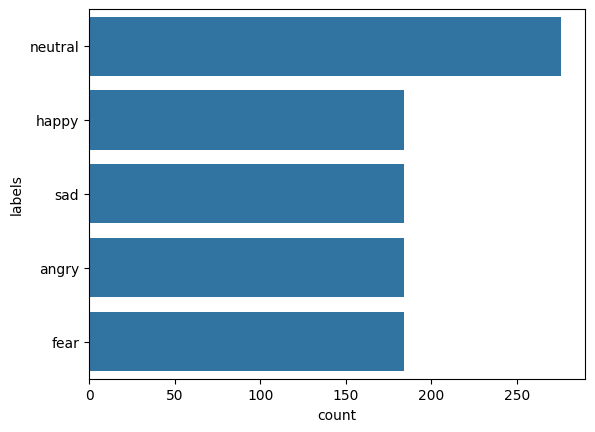

In [59]:
sea.countplot(ravdess_Dataframe['labels'])

In [60]:
cremad_emotion_mapping = {
    'NEU': 'neutral',
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'SAD': 'sad'
}

In [61]:
cremad_paths = []

for path in os.listdir(CREMAD_dataset):
    paths = os.path.join(CREMAD_dataset,path)
    cremad_paths.append(paths)

In [62]:
cremad_features=[map_audio_features(path,3,cremad_emotion_mapping,"_") for path in cremad_paths]

In [63]:
cremad_Dataframe = pd.DataFrame(cremad_features,columns = ["paths","labels"])

<Axes: xlabel='count', ylabel='labels'>

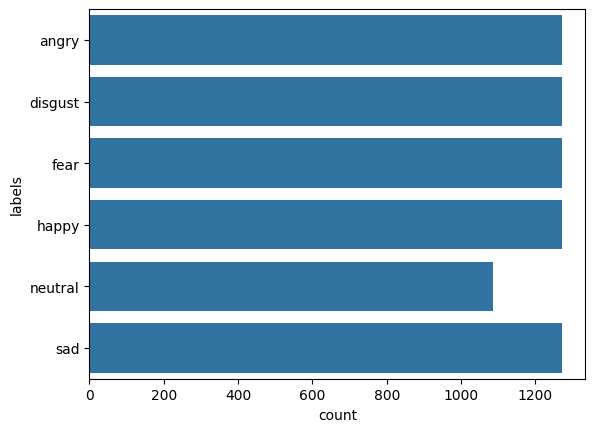

In [64]:
sea.countplot(cremad_Dataframe['labels'])

In [65]:
wav_path="C:/Users/levent/Downloads/Compressed/archive_3/IEMOCAP_full_release/Session1/sentences/wav"

wav_files_list=[]
for ses in os.listdir(IEMOCAP_wav_path):
    ses_files=os.path.join(IEMOCAP_wav_path,ses)
    wav_files_list.append(ses_files)

In [66]:
labels_path="C:/Users/levent/Downloads/Compressed/archive_3/IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Categorical"

labels_path_list=[]
for categoris in os.listdir(IEMOCAP_labels_path):
    categori=os.path.join(IEMOCAP_labels_path,categoris)
    file_extension = os.path.splitext(categori)[1].lstrip('.')
    if file_extension == "txt":
        labels_path_list.append(categori) 

In [67]:
import re
matched_pair=None
list_of_data=[]
for txts_path in labels_path_list:
    for path in wav_files_list:
        for wavs in os.listdir(path):
            wav=os.path.join(path,wavs)
            with open(txts_path, 'r') as txts: 
                for line in txts:
                   parts = line.split(':')
                   label = parts[1].split(';')[0]
                   wav_files = parts[0].strip()
                   file_extension = os.path.splitext(wav)[1].lstrip('.') 
                   if file_extension == "wav": 
                       if re.search(re.escape(wav_files), wav):
                            matched_pair = [wav, label]
                            list_of_data.append(matched_pair)

In [68]:
list_of_data

[['C:/Users/levent/Downloads/Compressed/archive_3/IEMOCAP_full_release/Session1/sentences/wav\\Ses01F_impro01\\Ses01F_impro01_F000.wav',
  'Neutral state'],
 ['C:/Users/levent/Downloads/Compressed/archive_3/IEMOCAP_full_release/Session1/sentences/wav\\Ses01F_impro01\\Ses01F_impro01_F001.wav',
  'Neutral state'],
 ['C:/Users/levent/Downloads/Compressed/archive_3/IEMOCAP_full_release/Session1/sentences/wav\\Ses01F_impro01\\Ses01F_impro01_F002.wav',
  'Neutral state'],
 ['C:/Users/levent/Downloads/Compressed/archive_3/IEMOCAP_full_release/Session1/sentences/wav\\Ses01F_impro01\\Ses01F_impro01_F003.wav',
  'Neutral state'],
 ['C:/Users/levent/Downloads/Compressed/archive_3/IEMOCAP_full_release/Session1/sentences/wav\\Ses01F_impro01\\Ses01F_impro01_F004.wav',
  'Neutral state'],
 ['C:/Users/levent/Downloads/Compressed/archive_3/IEMOCAP_full_release/Session1/sentences/wav\\Ses01F_impro01\\Ses01F_impro01_F005.wav',
  'Neutral state'],
 ['C:/Users/levent/Downloads/Compressed/archive_3/IEMOCAP_

In [69]:
import pandas as pd 
import seaborn as sea
iemocap_Dataframe=pd.DataFrame(list_of_data,columns=["paths","labels"])

<Axes: xlabel='count', ylabel='labels'>

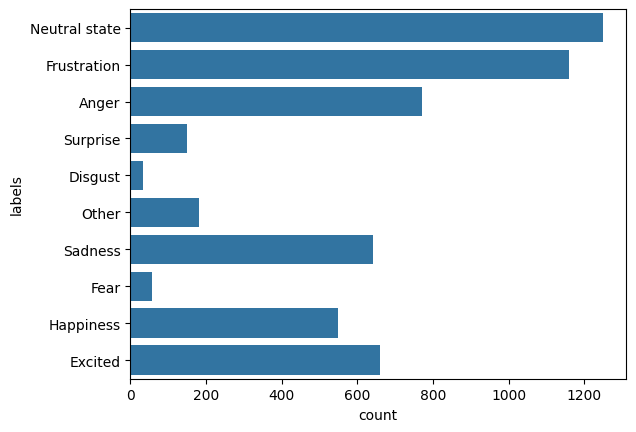

In [70]:
sea.countplot(iemocap_Dataframe['labels'])

In [71]:
label_mapping = {
    "Neutral state": "neutral",
    "Anger": "angry",
    "Surprise": "surprise",
    "Sadness": "sad",
    "Excited": "surprise",
    "Happiness": "happy" 
}

iemocap_Dataframe.loc[:, 'labels'] = iemocap_Dataframe['labels'].replace(label_mapping)

In [72]:
Filtered_iemocap_data = iemocap_Dataframe[~iemocap_Dataframe['labels'].isin(['Fear', 'Disgust','disgust','Other','Frustration','angry','sad','happy'])]

<Axes: xlabel='count', ylabel='labels'>

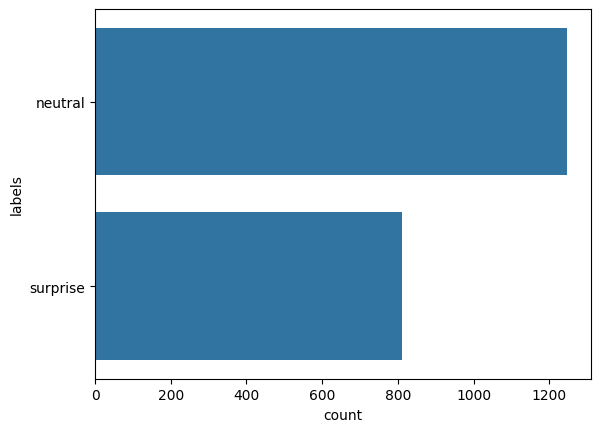

In [73]:
sea.countplot(Filtered_iemocap_data['labels'])

In [74]:
Tess_emotion_mapping = {
    'angry': 'angry',
    'disgust': 'disgust',
    'fear': 'fear',
    'happy': 'happy',
    'neutral': 'neutral',
    'sad': 'sad',
    'ps': 'surprise'
}

In [75]:
Tess_paths = []
for folders in os.listdir(TESS_dataset):
    folder = os.path.join(TESS_dataset,folders)
    for paths in os.listdir(folder):
        path = os.path.join(folder,paths)
        Tess_paths.append(path)

In [76]:
tess_features = [map_audio_features(path,-1,Tess_emotion_mapping,"_") for path in Tess_paths]

In [77]:
Tess_Dataframe = pd.DataFrame(tess_features,columns=["paths","labels"])

In [78]:
Tess_Dataframe['labels'].value_counts()

labels
angry       400
disgust     400
neutral     400
surprise    400
sad         400
fear        399
happy       399
Name: count, dtype: int64

In [79]:
savee_emotion_mapping = {
    'a': 'angry',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happy',
    'n': 'neutral',
    'sa': 'sad',
    'su': 'surprise'
}

In [80]:
Savee_paths = []
for path in os.listdir(SAVEE_dataset):
    paths = os.path.join(SAVEE_dataset,path)    
    Savee_paths.append(paths)

In [81]:
savee_features = [map_audio_features(path,-1,savee_emotion_mapping,"_") for path in Savee_paths]

In [82]:
savee_Dataframe = pd.DataFrame(savee_features,columns=["paths","labels"])

In [83]:
savee_Dataframe['labels'].value_counts()

labels
neutral     120
angry        60
disgust      60
fear         60
happy        60
sad          60
surprise     60
Name: count, dtype: int64

In [84]:
Total_Data=[]
Total_Data.append(savee_Dataframe)
Total_Data.append(Filtered_iemocap_data)
Total_Data.append(Tess_Dataframe)
Total_Data.append(ravdess_Dataframe)
Total_Data.append(cremad_Dataframe)
Big_data=pd.concat(Total_Data,ignore_index=True)

In [85]:
Filtered_data = Big_data[~Big_data['labels'].isin(['fear', 'disgust'])]
# İstemeyen duygu durumları çıkarıldı

<Axes: xlabel='count', ylabel='labels'>

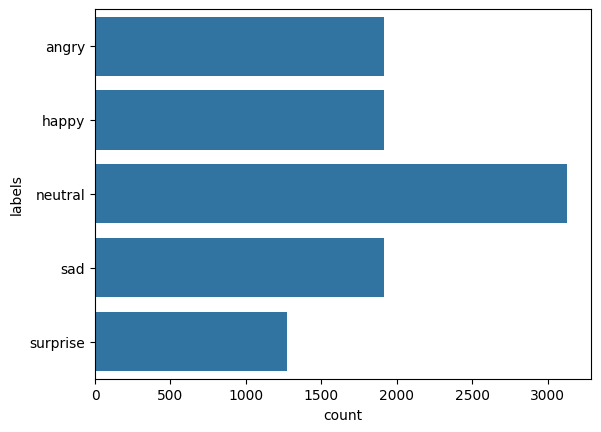

In [86]:
sea.countplot(Filtered_data['labels'])

In [87]:
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler,MinMaxScaler

def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=64).T, axis=0)
    return mfcc

In [88]:
with tf.device('/GPU:0'):
    X_mfcc = Filtered_data['paths'].apply(lambda x: extract_mfcc(x))   
    pass

In [89]:
X_mfcc

0        [-286.4318, 128.34483, 10.6623535, 33.634502, ...
1        [-269.42822, 136.77187, -15.110327, 17.623636,...
2        [-290.491, 118.30857, -4.742948, 27.052511, 8....
3        [-259.2938, 119.536385, 3.1149025, 16.472425, ...
4        [-277.33865, 107.37382, -5.3911524, 19.654114,...
                               ...                        
13785    [-445.2183, 116.697975, 7.135272, 65.59019, -1...
13786    [-376.2702, 119.78738, 4.149678, 45.470234, -2...
13789    [-373.89056, 125.2806, -2.8478541, 54.36043, -...
13790    [-404.8829, 124.196915, 13.040499, 43.833916, ...
13791    [-454.50098, 130.466, 9.12131, 55.879097, -15....
Name: paths, Length: 10147, dtype: object

<Axes: xlabel='count', ylabel='labels'>

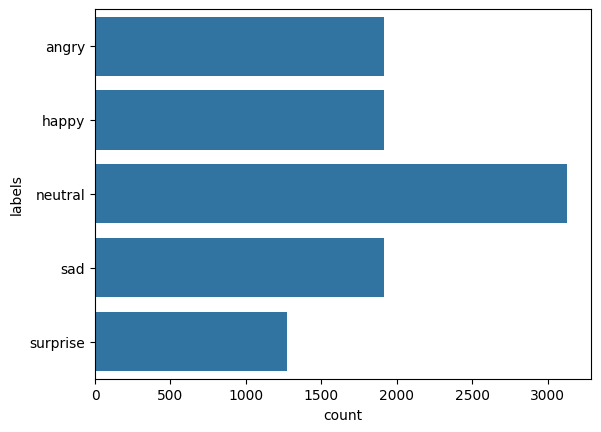

In [90]:
sea.countplot(Filtered_data['labels'])

In [91]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(10147, 64)

In [92]:
X

array([[-2.86431793e+02,  1.28344833e+02,  1.06623535e+01, ...,
         4.17775011e+00,  3.82219768e+00,  3.55802369e+00],
       [-2.69428223e+02,  1.36771866e+02, -1.51103268e+01, ...,
         4.01168633e+00,  3.35791755e+00,  3.16551828e+00],
       [-2.90490997e+02,  1.18308571e+02, -4.74294806e+00, ...,
         4.26444244e+00,  3.42640591e+00,  2.41148281e+00],
       ...,
       [-3.73890564e+02,  1.25280602e+02, -2.84785414e+00, ...,
        -1.86355972e+00,  6.05308294e-01,  5.28163128e-02],
       [-4.04882904e+02,  1.24196915e+02,  1.30404987e+01, ...,
        -1.21868944e+00,  8.10318470e-01, -1.99092224e-01],
       [-4.54500977e+02,  1.30466003e+02,  9.12131023e+00, ...,
        -2.55452752e+00,  3.79305780e-01,  2.78714240e-01]], dtype=float32)

In [93]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y = enc.fit_transform(Filtered_data['labels'])

In [94]:
y = y.astype('float32')

In [95]:
y.shape

(10147,)

In [96]:
y[:50]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
      dtype=float32)

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val =train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)

In [98]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [99]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [100]:
predictions=rf_model.predict(X_test)

In [101]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.80      0.75      0.78       187
         1.0       0.69      0.65      0.67       191
         2.0       0.75      0.81      0.78       326
         3.0       0.80      0.83      0.81       183
         4.0       0.88      0.78      0.83       128

    accuracy                           0.77      1015
   macro avg       0.78      0.76      0.77      1015
weighted avg       0.77      0.77      0.77      1015



In [102]:
X_train.shape

(8117, 64)

In [103]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)
x_valcnn = np.expand_dims(X_val, axis=2)

In [104]:
x_traincnn.shape

(8117, 64, 1)

In [202]:
	from tensorflow.keras.layers import Input, Concatenate, Conv1D, MaxPooling1D,LSTM, Embedding
	from tensorflow.keras.models import Model,load_model
	
	# İmage model 
	
	image_model = Sequential([
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='same',input_shape=(img_shape), kernel_regularizer=tf.keras.regularizers.l2(0.0001)),  
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),
    
        Conv2D(filters=128, kernel_size=(3, 3), padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        
        Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)), 
        Dropout(0.2),
        
        Conv2D(filters=512, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(filters=1024, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        
        GlobalAveragePooling2D()
	 ])
	
	# audio model
	
	audio_model = Sequential()

audio_model.add(Conv1D(128, 5, padding='same', input_shape=(64, 1), kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
audio_model.add(BatchNormalization())
audio_model.add(Activation('relu'))
audio_model.add(MaxPooling1D(pool_size=(2)))

audio_model.add(Conv1D(128, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
audio_model.add(BatchNormalization())
audio_model.add(MaxPooling1D(pool_size=(4)))
audio_model.add(Dropout(0.5))

audio_model.add(Flatten())

# Text model
text_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_sequence_length),
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.5),
 
    Flatten()
])

image_input = Input(shape = (48, 48, 1), name="input_1")
audio_input = Input(shape = (64, 1), name="input_2")
text_input = Input(shape = (64,), name="input_3")

image_output = image_model(image_input)
audio_output = audio_model(audio_input)
text_output = text_model(text_input)

combined = Concatenate()([image_output, audio_output, text_output])
combined = Dense(256, activation="relu")(combined)
combined = Dense(128, activation="relu")(combined)
combined = Dropout(0.3)(combined)
combined = Dense(64, activation="relu")(combined)

final_output = Dense(5, activation='softmax')(combined)

multimodal_model = Model(inputs=[image_input, audio_input, text_input ], outputs=final_output)


In [203]:
multimodal_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [204]:
multimodal_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 1)]      0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 sequential_24 (Sequential)     (None, 1024)         6277376     ['input_1[0][0]']                
                                                                                            

In [205]:
train_gen

In [206]:
def multimodal_generator(image_gen, audio_data, audio_labels, text_data):
    while True:
        x_image, y_image = next(image_gen)  
        x_audio = audio_data[:len(x_image)]  
        x_text = text_data[:len(x_image)]
        x_audio = tf.reshape(x_audio, (len(x_image), 64))

        yield {"input_1": x_image, "input_2": x_audio, "input_3": x_text}, y_image

In [207]:
train_new = multimodal_generator(train_gen,x_traincnn,y_train,x_text_train)
val_new = multimodal_generator(val_gen,x_valcnn,y_val, x_text_val)
test_new = multimodal_generator(test_gen,x_testcnn,y_test,x_text_test)

In [208]:
steps_per_epoch = len(y_train) // batch_size
validation_steps = len(y_val) // batch_size
steps = len(y_test) // batch_size

In [209]:
Early_Stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                                  patience = 60, 
                                                  restore_best_weights = True, 
                                                  verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5,  
                                 patience=40, 
                                 min_lr=0.0001)


history = multimodal_model.fit(
    train_new,           
    batch_size=64,
    epochs=500,
    validation_data=val_new,
    validation_steps=validation_steps,
    steps_per_epoch=steps_per_epoch,
    callbacks=[Early_Stopping,lr_scheduler]
) 

Epoch 1/500
126/126 [==============================] - 17s 115ms/step - loss: 1.6844 - accuracy: 0.2682 - val_loss: 1.7152 - val_accuracy: 0.2219 - lr: 0.0010
Epoch 2/500
126/126 [==============================] - 14s 111ms/step - loss: 1.6253 - accuracy: 0.2752 - val_loss: 1.6323 - val_accuracy: 0.2227 - lr: 0.0010
Epoch 3/500
126/126 [==============================] - 14s 111ms/step - loss: 1.5761 - accuracy: 0.3108 - val_loss: 1.8347 - val_accuracy: 0.1910 - lr: 0.0010
Epoch 4/500
126/126 [==============================] - 15s 116ms/step - loss: 1.4790 - accuracy: 0.3610 - val_loss: 1.9664 - val_accuracy: 0.2781 - lr: 0.0010
Epoch 5/500
126/126 [==============================] - 14s 112ms/step - loss: 1.4081 - accuracy: 0.3903 - val_loss: 2.4977 - val_accuracy: 0.3373 - lr: 0.0010
Epoch 6/500
126/126 [==============================] - 14s 112ms/step - loss: 1.3470 - accuracy: 0.4324 - val_loss: 1.5839 - val_accuracy: 0.3875 - lr: 0.0010
Epoch 7/500
126/126 [=========================

In [210]:
multimodal_model.evaluate(test_new, steps=steps)

15/15 [==============================] - 1s 43ms/step - loss: 0.6066 - accuracy: 0.7865


[0.6065568923950195, 0.7864583134651184]

In [219]:
multimodal_model.save('Multimodal78.h5')

In [211]:
def plot_training_history(history):
    
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

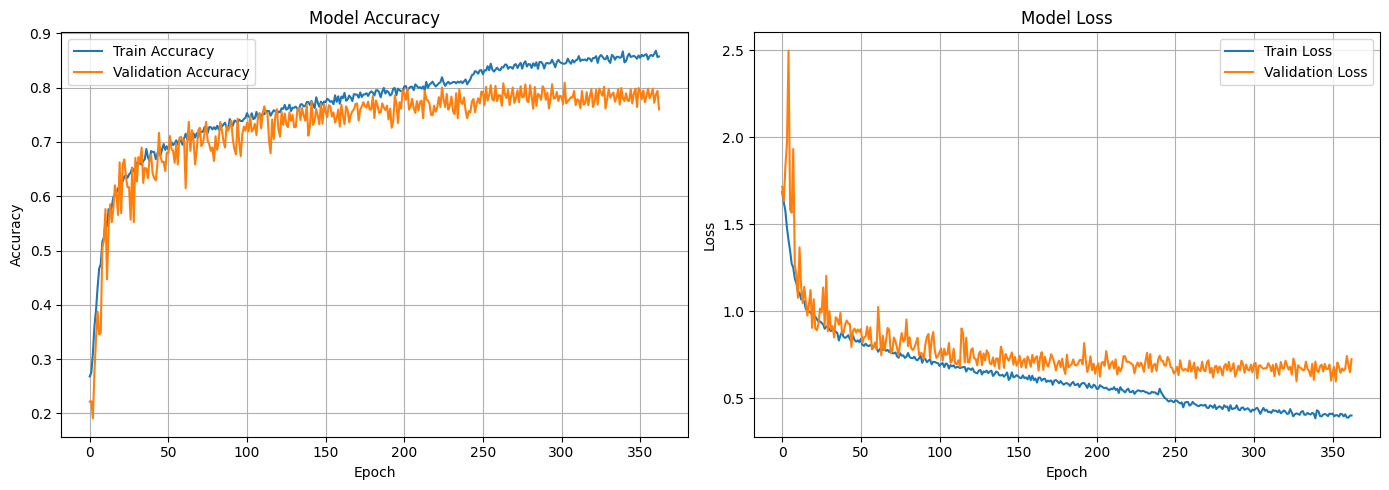

In [212]:
plot_training_history(history)

In [213]:
steps2 = len(y_test) // 64 

In [214]:
steps2

15

In [215]:
y_pred_list = []
y_true_list = []

steps = len(y_test) // 64 
for _ in range(steps):
    x, y_true_batch = next(test_new) 
    y_pred_probs_batch = multimodal_model.predict(x, verbose=0) 
    y_pred_batch = np.argmax(y_pred_probs_batch, axis=1)  
    y_true_batch = y_true_batch.astype(int) 

    y_pred_list.extend(y_pred_batch.tolist())  
    y_true_list.extend(y_true_batch.tolist())  

In [216]:
y_true_batch

array([2, 1, 3, 2, 2, 3, 4, 3, 1, 1, 4, 1, 1, 3, 0, 1, 1, 2, 3, 1, 2, 1,
       2, 1, 0, 2, 1, 1, 0, 0, 1, 3, 4, 0, 3, 3, 1, 1, 4, 1, 0, 3, 3, 1,
       1, 1, 3, 1, 0, 2, 4, 2, 4, 2, 2, 2, 1, 0, 1, 3, 3, 2, 4, 2])

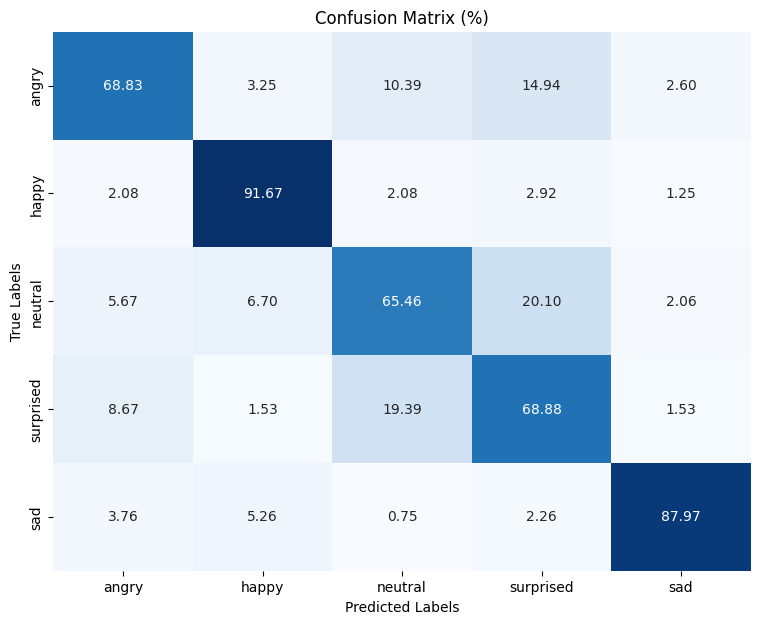

In [217]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

y_pred = np.array(y_pred_list)
y_true = np.array(y_true_list)

# Confusion matrix oluştur
cm = confusion_matrix(y_true, y_pred)

# Sınıf etiketlerini belirtin
class_labels = ['angry', 'happy', 'neutral', 'surprised', 'sad']

# Confusion matrix'i DataFrame olarak düzenle
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Yüzdelik matrisi hesapla
cm_percentage = cm_df.div(cm_df.sum(axis=1), axis=0).multiply(100).round(2)

# Matrisi çiz
plt.figure(figsize=(9, 7))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (%)")
plt.show()


In [218]:
import json

def count_code_lines(notebook_path):
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook_data = json.load(f)
    
    total_lines = 0
    for cell in notebook_data.get('cells', []):
        if cell.get('cell_type') == 'code':
            total_lines += len(cell.get('source', []))
    
    return total_lines

# Not defterinin yolunu belirtin
notebook_path = "Multimodal.ipynb"  # Örneğin, "notebook.ipynb"
total_lines = count_code_lines(notebook_path)

In [149]:
total_lines

595